In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from gcode_generator import G_code_generator
from gcode_functions import get_print_limits
from plotting_functions import plot_defined_regions
from tool_changer_functions import (
    save_params, 
    load_params, 
    printer_start, 
    load_tool, 
    unload_tool, 
    tool_change, 
    take_photo, 
    play_sound, 
    printer_stop)

# Defining materials, parameter, dimensions

In [31]:
print_params = {
    'PLA': load_params('printing_params/PLA_default.json'),
    'TPU': load_params('printing_params/TPU_default.json'),
}

In [41]:
# g-code generators
gen_PLA = G_code_generator(print_params['PLA'])
gen_TPU = G_code_generator(print_params['TPU'])

## Defining regions

In [43]:
regions = {
    'PLA': {
        'layer': 1,
        'z_height': None,
        'region_type': 'surface',
        'material': 'conductive',
        'position': [155, 120],
        'dimensions': [20, 20],
        'start_pos': ['x1', 'y1'],
        'infill_angle': 0,
        'perimeter': True,
        'overlap_factor': 0.25,
        'speed_factor': 1.0,
        'extrude_factor': 1.0,
        'heading': 'PLA surface'        
    },
    'TPU': {
        'layer': 2,
        'z_height': None,
        'region_type': 'surface',
        'material': 'piezoelectric',
        'position': [157.5, 122.5],
        'dimensions':  [15, 15],
        'start_pos': ['x1', 'y1'],
        'infill_angle': 90,
        'perimeter': False,
        'overlap_factor': 0.25,
        'speed_factor': 1.0,
        'extrude_factor': 1.0,
        'heading': 'TPU surface'          
    }
}

**Plotting regions**

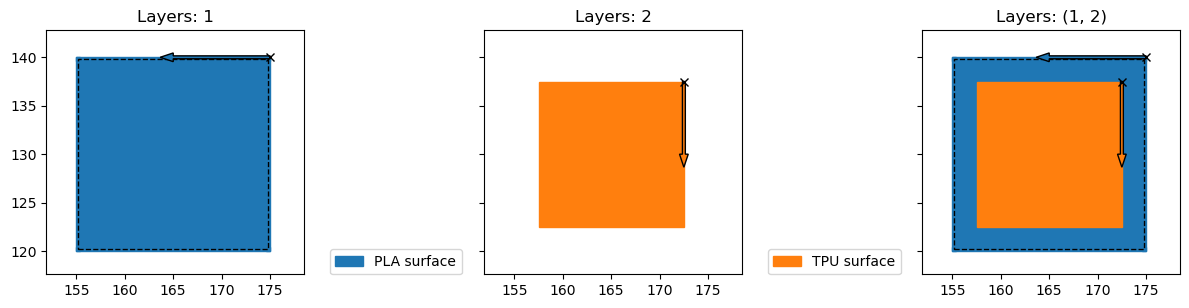

In [44]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
plot_defined_regions(fig, axes[0], regions, layer=1)
plot_defined_regions(fig, axes[1], regions, layer=2)
plot_defined_regions(fig, axes[2], regions, layer=(1,2))
# axes[0].set_xlim(0, 300)
# axes[0].set_ylim(0, 200)
plt.tight_layout()

## Printer settings

In [45]:
print_limits = get_print_limits(regions)
printer_settings = {
    'tools': {
        'PLA': 'T3',
        'TPU': 'T1'
    },
    'temps': {
        'PLA': None,
        'TPU': None,
        'bed': 60
    },
    'cooling':{
        'PLA': None,
        'TPU': None
    },
    'prime_macro': {
        'PLA': 'prime',
        'TPU': 'prime'
    },
    'mesh_bed': {
        'X': [print_limits['x_min'], print_limits['x_max']],
        'Y': [print_limits['y_min'], print_limits['y_max']],
        'P': 5
    }
}

for material, tool in printer_settings['tools'].items():
    temps = [print_params[material]['T_nozzle'],
             print_params[material]['T_nozzle_standby']]
    printer_settings['temps'][material] = temps
    cooling = print_params[material]['cooling']
    printer_settings['cooling'][material] = cooling

printer_settings

{'tools': {'PLA': 'T3', 'TPU': 'T1'},
 'temps': {'PLA': [215, 200], 'TPU': [230, 180], 'bed': 60},
 'cooling': {'PLA': 1, 'TPU': 0.3},
 'prime_macro': {'PLA': 'prime', 'TPU': 'prime'},
 'mesh_bed': {'X': [155.0, 175.0], 'Y': [120.0, 140.0], 'P': 5}}

# G-code generation

**Printer start**

In [46]:
g_code = printer_start(printer_settings)
# print(g_code)

**Loading tool**

In [47]:
g_code += load_tool(
    material='PLA',
    printer_settings=printer_settings
)

**Printing first region - conductive**

In [48]:
g_code += '; print surface - conductive - start\n'
g_code += gen_PLA.print_region(regions['PLA'])
g_code += '; print surface - conductive - end\n\n'

**Tool change**

In [49]:
g_code += tool_change(
    current_material='PLA', 
    next_material='TPU',
    printer_settings=printer_settings
)

**Printing second region - PVDF**

In [50]:
g_code += '; print surface - piezoelectric - start\n'
g_code += gen_TPU.print_region(regions['TPU'])
g_code += '; print surface - piezoelectric - end\n\n'

**Unload tool**

In [51]:
g_code += unload_tool(
    material='TPU',
    printer_settings=printer_settings
)

**Printer stop**

In [52]:
g_code += printer_stop()

In [53]:
print(g_code)

; --- Printer start g-code - start
T3 P0 ; activating tool T3
T1 P0 ; activating tool T1
T-1 P0 ; clear tool selection

G10 P3 S215 ; set tool 3 extruder temp
G10 P3 R200 ; set tool 3 idle temp
G10 P1 S230 ; set tool 1 extruder temp
G10 P1 R180 ; set tool 1 idle temp
M302 S120 ; set cold extrusion limit
M140 S60 ; set bed temp
M190 S60 ; wait for bed temp

T-1 ; clear tool selection
G28 ; home all
M557 X155.0:175.0 Y120.0:140.0 P5 ; mesh bed leveling
G29 ; probe the bed, save the height map, and activate bed compensation
G21 ; set units to millimeters
G90 ; use absolute coordinates
M83 ; use relative distances for extrusion
T-1 ; clear tool selection
; --- Printer start g-code - end

; --- Tool load: T3 : PLA - start
T-1 ; clear tool selection
T3 ; load tool
M116 P3 ; wait for extruder to reach temp.
M106 P8 S1 ; turn on PCF for mounted tool
M98 P"prime.g" ; prime extruder
; --- Tool load: T3 - end

; print surface - conductive - start
G0 X174.790 Y139.790 Z0.400 E0.0 F30000 ; move ove

**Saving g-code**

In [55]:
filepath = 'generated_gcodes/test'
with open(filepath + '.gcode', 'w') as f:
    f.write(g_code)

In [56]:
from gcode_functions import process_g_code

In [57]:
process_g_code(filepath + '.gcode', tool_unload_time=3, tool_load_time=10)

{'print_time_hours': 0.03,
 'print_time_mins': 1.94,
 'print_time_sec': 116.43,
 'all_extrusions_mm': 44.99,
 'print_duration_sec': 54.87,
 'only_extrusion_duration_sec': 0.56,
 'tool_unloads_duration': 21,
 'tool_loads_duration': 40}